In [1]:
%%capture
import pandas as pd
import numpy as np
from datetime import datetime
import functools as ft

!pip install matplotlib
import matplotlib.pyplot as plt

!pip install yfinance
import yfinance as yf

In [2]:
pd.set_option('display.max_rows', 25)

TODAY = datetime.today().strftime('%Y-%m-%d')
START = '2015-01-01'
END = TODAY

In [3]:
mining_stocks = {"Rio Tinto" : "RIO.AX", "Newcrest Mining" : "NCM.AX", "BHP" : "BHP.AX", "Fortescue" : "FMG.AX", "South32" : "S32.AX", "Northern Star" : "NST.AX", "Mineral Resources" : "MIN.AX", "Evolution Mining" : "EVN.AX", "IGO" : "IGO.AX", "Pilbara Minerals" : "PLS.AX"}
mineral_codes = {"Gold" : "GC=F", "Silver" : "SI=F", "Platinum" : "PL=F", "Copper" : "HG=F", "Palladium" : "PA=F", "Crude Oil" : "CL=F", "Heating Oil" : "HO=F", "Natural Gas" : "NG=F"}

In [33]:
big_df = yf.download(list(mining_stocks.values()), START, END)

[*********************100%***********************]  10 of 10 completed


## Price vs Float

In [15]:
def df_price_volume(stock, stock_name, price_series, start_date, end_date=None):
    tickobj = yf.Ticker(stock)
    tickobj_float = tickobj.get_shares_full(start = start_date, end = end_date)
    
    volume = pd.DataFrame(data = tickobj_float)
    volume.reset_index(drop=False, inplace=True)
    volume.rename(columns={"index" : "Datetime", 0 : stock_name + " float"}, inplace=True)
    volume['Datetime'] = volume['Datetime'].dt.tz_localize(None)
    volume["Datetime"] = pd.to_datetime(volume["Datetime"], format="%d/%m/%Y")
    
    price = pd.DataFrame(price_series)
    price.reset_index(drop=False, inplace=True)
    price.rename(columns={"Date" : "Datetime"}, inplace=True)
    
    price_volume = pd.merge(price, volume, how="outer", on="Datetime", sort=True)
    price_volume = price_volume.loc[price_volume["Datetime"] > start_date]
    price_volume[stock_name + " float"].interpolate(inplace=True)
    price_volume[stock].interpolate(inplace=True)
    
    return price_volume

def plot_price_volume(stock, stock_name, price_series, start_date, end_date=None):
    plt.style.use('fivethirtyeight')
    plt.rcParams['figure.figsize'] = (16, 5)
    
    price_volume = df_price_volume(stock, stock_name, price_series, start_date, end_date)
    
    fig, ax1 = plt.subplots()
    
    ax1.plot(price_volume["Datetime"], price_volume[stock_name + " float"])
    ax1.xaxis.grid()
    ax1.yaxis.grid()
    ax1.set_ylabel("Public Stock Float Quantity")
    
    ax2 = ax1.twinx()
    ax2.plot(price_volume["Datetime"], price_volume[stock], "orange")
    ax2.set_ylabel("Price (AUD)")
    
    fig.legend(["Stock float", "Stock price"])
    fig.suptitle(stock_name)
    plt.show()

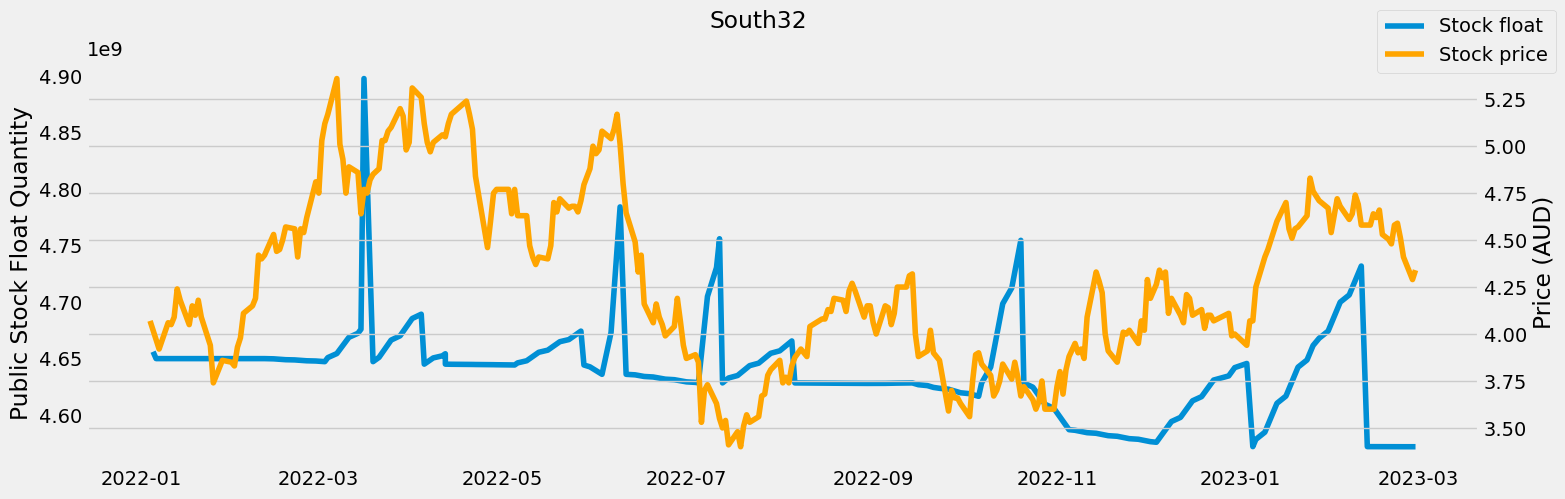

In [16]:
plot_price_volume("S32.AX", "South32", big_df["Close"]["S32.AX"], "2022-01-01")

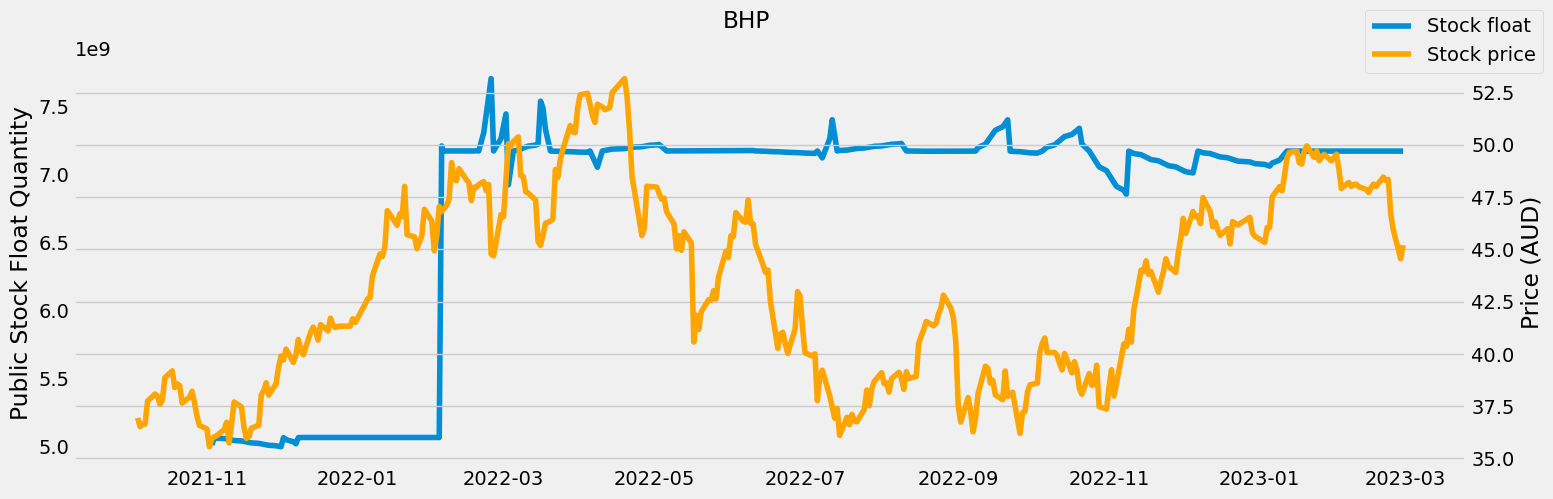

In [17]:
plot_price_volume("BHP.AX", "BHP", big_df["Close"]["BHP.AX"], "2021-10-01")

## Stock Volatility

In [18]:
# Naive volatility
def volatility(price_series):
    expectation_value = price_series.dropna().mean()
    total_squared_deviation = np.sum((price_series - expectation_value) ** 2)
    variance = total_squared_deviation / len(price_series.dropna())
    return variance

# Volatility with a rolling window
def volatility_roll(price_series, window):
    df = pd.DataFrame(price_series.dropna())
    df["expectation_value"] = price_series.rolling(window).mean()
    df["variance"] = np.nan
    for i in range(window - 1, len(df)):
        df["variance"][i] = ((df.iloc[:,0][i - window + 1: i + 1] - df["expectation_value"][i]) ** 2).sum() / window
    return df["variance"]

def plot_volatility(price_series, window):
    plt.style.use('fivethirtyeight')
    plt.rcParams['figure.figsize'] = (16, 5)
    
    variance = volatility_roll(price_series, window)
    
    fig, ax = plt.subplots()
    
    ax.plot(variance)
    ax.xaxis.grid()
    ax.yaxis.grid(True)
    ax.set_ylabel("Volatility")
    
    fig.suptitle("Rolling volatility over {} days".format(window))
    plt.show()

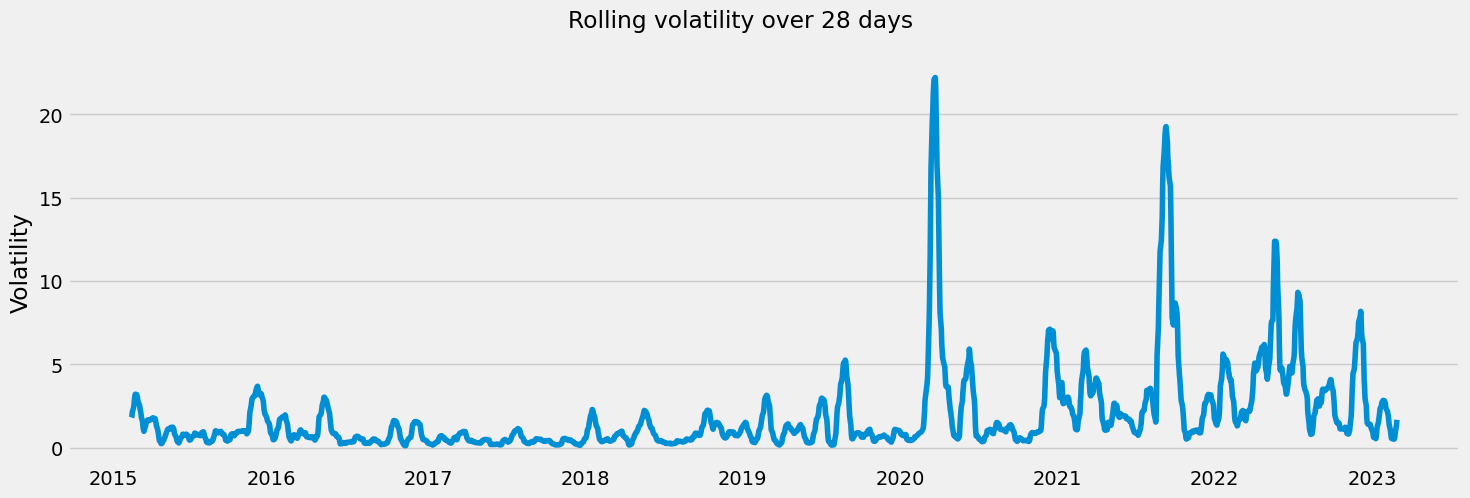

In [19]:
plot_volatility(big_df["Close"]["BHP.AX"], 28)

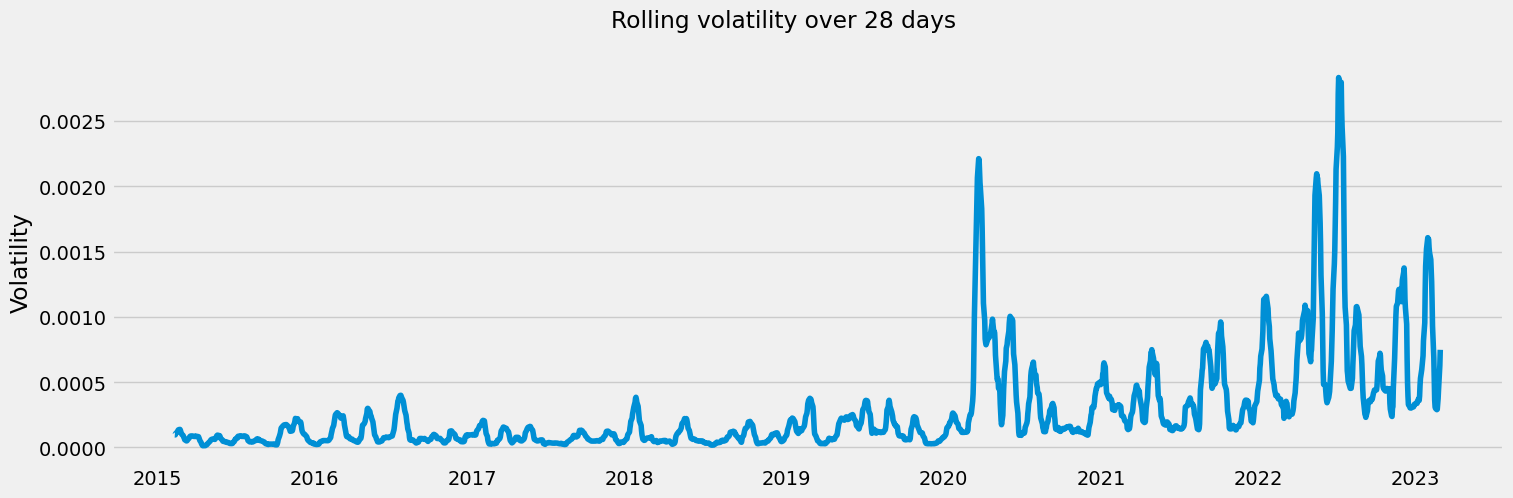

In [26]:
plot_volatility((big_df["Close"] / big_df["Close"].max()).mean(axis=1), 28)

In [20]:
big_df["Close"]

,BHP.AX,EVN.AX,FMG.AX,IGO.AX,MIN.AX,NCM.AX,NST.AX,PLS.AX,RIO.AX,S32.AX
Date,,,,,,,,,,
2015-01-02,27.603399,0.601150,2.830000,4.45,7.860000,10.960000,1.51,0.044,58.330002,NaN
2015-01-05,27.547335,0.647039,2.820000,4.51,8.370000,11.450000,1.58,0.044,58.480000,NaN
2015-01-06,26.267149,0.679162,2.790000,4.48,8.010000,11.730000,1.67,0.044,57.590000,NaN
2015-01-07,26.267149,0.734229,2.740000,4.39,7.810000,11.690000,1.71,0.048,57.290001,NaN
2015-01-08,26.519447,0.715874,2.670000,4.40,7.760000,11.640000,1.65,0.049,58.650002,NaN
...,...,...,...,...,...,...,...,...,...,...
2023-02-22,48.340000,2.800000,22.889999,13.24,83.910004,23.260000,10.64,4.260,125.510002,4.59
2023-02-23,46.689999,2.780000,22.830000,13.30,85.029999,23.200001,10.44,4.480,123.400002,4.51
2023-02-24,45.939999,2.700000,22.440001,13.45,84.910004,22.610001,10.41,4.530,118.919998,4.41


In [21]:
big_df["Close"].mean(axis=1)

Date
2015-01-02    12.687617
2015-01-05    12.827597
2015-01-06    12.584479
2015-01-07    12.519931
2015-01-08    12.672703
                ...    
2023-02-22    33.944001
2023-02-23    33.666000
2023-02-24    33.032000
2023-02-27    31.712000
2023-02-28    32.316000
Length: 2066, dtype: float64

In [22]:
(27.603399+0.601150+2.830000+4.45+7.860000+10.960000+1.51+0.044+58.330002)/9

12.687616777777777

In [25]:
(big_df["Close"] / big_df["Close"].max()).mean(axis=1)

Date
2015-01-02    0.208342
2015-01-05    0.211953
2015-01-06    0.209790
2015-01-07    0.209676
2015-01-08    0.210197
                ...   
2023-02-22    0.766369
2023-02-23    0.763900
2023-02-24    0.754583
2023-02-27    0.723977
2023-02-28    0.735301
Length: 2066, dtype: float64

## From article

In [28]:
import pandas as pd
import numpy as np
import requests
url = "https://yh-finance.p.rapidapi.com/stock/v2/get-financials" querystring = {"symbol":AAPL}
headers = {
"X-RapidAPI-Key": "***",
"X-RapidAPI-Host": "yh-finance.p.rapidapi.com"}
response = requests.request("GET", url, headers=headers, params=querystring)
df = response.json()
df1 = pd.json_normalize(df)
cashflow = df1.loc[:, df1.columns.str.contains('cashflowStatementHistoryQuarterly.cashflowStatements')]
incomestatement = df1.loc[:, df1.columns.str.contains('incomeStatementHistory.incomeStatementHistory')]
def clean(x,y):
 df = pd.DataFrame(x.iloc[0,0])
 df = df.loc[:, df.columns.str.contains(y)]
 df = pd.json_normalize(df[y])
 df = pd.DataFrame(df.raw)
 df.columns=[y]
 return(df)
ebit = clean(incomestatement,'incomeBeforeTax')
depreciation = clean(cashflow, 'depreciation')
capex = clean(cashflow,'capitalExpenditures')

SyntaxError: invalid syntax (684673818.py, line 4)